In [1]:
from __future__ import print_function, division

%reload_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
import argparse
import sys
from PIL import Image, ImageFile
import cv2

ImageFile.LOAD_TRUNCATED_IMAGES = True
import shutil
import torchsample
# custom datasets
from data_utils.miniplaces_dataset import MiniPlacesDataset
from techniques.generate_grounding import gen_grounding
from techniques.generate_batch import gen_grounding_gcam_batch, gen_grounding_bp_batch, gen_grounding_gbp_batch, gen_grounding_lime_batch, gen_grounding_ig_batch
from techniques.utils import pointing_game, jensenshannon, get_img_mask, get_displ_img

In [2]:
OBJ_NAMES = [
    'backpack', 'bird', 'dog', 'elephant', 'kite', 'pizza', 'stop_sign',
    'toilet', 'truck', 'zebra'
]
SCENE_NAMES = [
    'bamboo_forest', 'bedroom', 'bowling_alley', 'bus_interior', 'cockpit',
    'corn_field', 'laundromat', 'runway', 'ski_slope', 'track/outdoor'
]
data_dir = '/work/lisabdunlap/bam/data/scene/'

In [3]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomSizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #torchsample.transforms.RandomRotate(30),
        torchsample.transforms.RandomGamma(0.5, 1.5),
        torchsample.transforms.RandomSaturation(-0.8, 0.8),
        torchsample.transforms.RandomBrightness(-0.3, 0.3),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Scale(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/work/lisabdunlap/bam/data/scene/'

dsets = dict()
dsets['train'] = MiniPlacesDataset(
        photos_path=os.path.join(data_dir),
        labels_path=os.path.join(data_dir, 'train.txt'),
        transform=data_transforms['train'],
        train=True,
        location_paths=os.path.join(data_dir, 'loc_train.txt')
    )
dsets['val'] = MiniPlacesDataset(
        photos_path=os.path.join(data_dir),
        labels_path=os.path.join(data_dir, 'val2.txt'),
        transform=data_transforms['val'],
        train=False,
        location_paths=os.path.join(data_dir, 'loc_val.txt')
    )

dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=5,
                                               shuffle=True, num_workers=1)
                for x in ['train', 'val']}

dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_sizes

# images found at path '/work/lisabdunlap/bam/data/scene/train.txt': 90000
# images found at path '/work/lisabdunlap/bam/data/scene/val2.txt': 10000


{'train': 90000, 'val': 10000}

label:  0
path:  train/bamboo_forest/backpack-bamboo_forest-0001.jpg


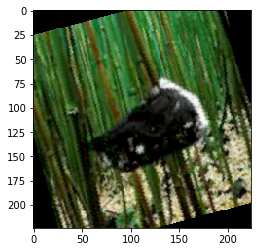

In [4]:
img, label, path, loc = dsets['train'][1]
print('label: ', label)
print('path: ', path)
sample_img = get_displ_img(img)
plt.imshow(sample_img)

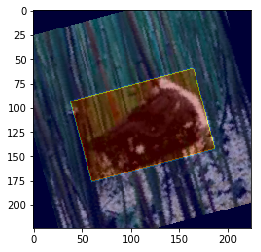

In [5]:
sample_mask = loc.numpy()[0]
sample_img = get_displ_img(img)
sample_mask = cv2.cvtColor(cv2.applyColorMap(np.uint8((sample_mask / np.max(sample_mask)) * 255.0), cv2.COLORMAP_JET),
                           cv2.COLOR_BGR2RGB)
alpha = .4
cam = sample_mask*alpha + np.float32(sample_img)*(1-alpha)
cam /= np.max(cam)
plt.imshow(cam)

In [6]:
device = torch.device("cuda:1")
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model =  nn.DataParallel(model, device_ids=[1])
model_state = torch.load('/work/lisabdunlap/bam/pytorch_models/one_dog_cold/model_best.pth.tar', map_location='cuda:1')
model.load_state_dict(model_state['state_dict'])
model.to(device)
print("top 1: {0}    top 5: {1}".format(model_state['best_top1'],model_state['best_top5']))

top 1: 82.99458312988281    top 5: 98.54336547851562


In [7]:
i = 0
correct_imgs = []
correct_labels = []
output_labels = []
correct = 0
for i, data in enumerate(dset_loaders['val']):
    inputs, labels, paths, locations = data
    inputs = Variable(inputs.float()).to(device)
    labels = Variable(labels.long()).to(device) 
    output = model(inputs)
    probabilities, prediction = output.topk(1, dim=1, largest=True, sorted=True)
    #print("labels: {0}".format(labels.cpu().numpy()))
    #print("predictions: {0}".format(prediction.cpu().numpy()))
    for p,l,inp in zip(prediction.cpu().numpy(), labels.cpu().numpy(), inputs):
        print("predicted: {0}  truth: {1}".format(SCENE_NAMES[p[0]], SCENE_NAMES[l]))
        if SCENE_NAMES[p[0]] == SCENE_NAMES[l]:
            correct_imgs += [inp]
            correct_labels += [p[0]]
    break

Traceback (most recent call last):
  File "/work/lisabdunlap/anaconda3/lib/python3.7/multiprocessing/util.py", line 265, in _run_finalizers
    finalizer()
  File "/work/lisabdunlap/anaconda3/lib/python3.7/multiprocessing/util.py", line 189, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/work/lisabdunlap/anaconda3/lib/python3.7/shutil.py", line 491, in rmtree
    _rmtree_safe_fd(fd, path, onerror)
  File "/work/lisabdunlap/anaconda3/lib/python3.7/shutil.py", line 449, in _rmtree_safe_fd
    onerror(os.unlink, fullname, sys.exc_info())
  File "/work/lisabdunlap/anaconda3/lib/python3.7/shutil.py", line 447, in _rmtree_safe_fd
    os.unlink(entry.name, dir_fd=topfd)
OSError: [Errno 16] Device or resource busy: '.nfs0000000004c170b500008ff0'


predicted: laundromat  truth: bamboo_forest
predicted: cockpit  truth: cockpit
predicted: runway  truth: runway
predicted: bus_interior  truth: corn_field
predicted: bedroom  truth: bedroom


In [8]:
from techniques.generate_batch import gen_grounding_bp_batch, gen_grounding_gbp_batch, gen_grounding_lime_batch
bps = gen_grounding_gbp_batch(imgs=inputs, 
                            model=model.module, 
                            label_name='explanation',
                            #target_index=labels, 
                            device=1,  
                            save=True, 
                            from_saved=False, 
                            topk=False, 
                            save_path='./examples/', 
                            classes=SCENE_NAMES,
                            show=False)

result path: ./examples/


In [9]:
from techniques.generate_batch import gen_grounding_bp_batch, gen_grounding_gbp_batch, gen_grounding_lime_batch
gbps = gen_grounding_gbp_batch(imgs=inputs, 
                            model=model.module, 
                            label_name='explanation',
                            #target_index=labels, 
                            device=1,  
                            save=True, 
                            from_saved=False, 
                            topk=False, 
                            save_path='./examples/', 
                            classes=SCENE_NAMES,
                            show=False)

result path: ./examples/


In [10]:
gcams = gen_grounding_gcam_batch(imgs=inputs[:4], 
                            model=model.module, 
                            label_name='explanation',
                            #target_index=labels, 
                            device=1,  
                            save=False, 
                            from_saved=False, 
                            topk=True, 
                            save_path='./examples/', 
                            classes=SCENE_NAMES,
                            show=False)

In [11]:
limes = gen_grounding_lime_batch(imgs=inputs[:4], 
                        model=model.module, 
                        label_name='explanation',
                        target_index=labels, 
                        device=0,  
                        save=False, 
                        from_saved=False, 
                        topk=True, 
                        save_path='./examples/', 
                        classes=SCENE_NAMES,
                        show=False)

explained
explained
explained
explained
finished lime explanation


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


224


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


224


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


224
224
finished Integrated Gradients explanation


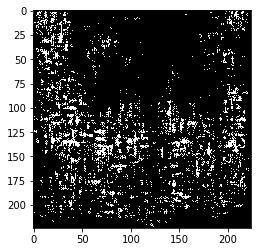

In [12]:
igs = gen_grounding_ig_batch(imgs=inputs[:4], 
                        model=model.module, 
                        label_name='explanation',
                        target_index=labels, 
                        device=0,  
                        save=False, 
                        from_saved=False, 
                        topk=True, 
                        save_path='./examples/', 
                        classes=SCENE_NAMES,
                        show=False)

In [15]:
def get_cam(img, mask):
    heatmap = cv2.cvtColor(cv2.applyColorMap(np.uint8((mask / np.max(mask)) * 255.0), cv2.COLORMAP_JET),
                               cv2.COLOR_BGR2RGB)
    alpha = .6
    cam = heatmap*alpha + np.float32(img)*(1-alpha)
    cam /= np.max(cam)
    return cam

cams = []
for path,gcam,lime,bp,gbp,ig in zip(paths[:4], gcams, limes, bps, gbps, igs):
    img = cv2.resize(cv2.imread(data_dir+path), (224, 224))
    cams += [img]
    cams += [get_cam(img,gcam)]
    cams += [get_cam(img,lime)]
    cams += [get_cam(img,bp)]
    cams += [get_cam(img,gbp)]
    cams += [get_cam(img,ig)]

error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/colormap.cpp:516: error: (-5:Bad argument) cv::ColorMap only supports source images of type CV_8UC1 or CV_8UC3 in function 'operator()'


In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 6),
                 axes_pad=0.35,  # pad between axes in inch.
                 )

for ax, im in zip(grid, cams):
    ax.axis('off')
    # Iterating over the grid returns the Axes.
    ax.imshow(im)